In [154]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score
from sklearn.linear_model import LogisticRegression

In [155]:
NUM_DAYS = 10000    
INTERVAL = '1d'     
symbol = '^IXIC'

[*********************100%***********************]  1 of 1 completed
6894
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1994-08-18  742.270020  744.710022  740.159973  742.169983  742.169983   
1994-08-19  743.460022  743.830017  739.599976  742.429993  742.429993   
1994-08-22  741.760010  742.830017  740.520020  742.289978  742.289978   
1994-08-23  743.320007  749.539978  743.130005  747.979980  747.979980   
1994-08-24  748.130005  751.840027  747.719971  751.719971  751.719971   

               Volume  
Date                   
1994-08-18  335280000  
1994-08-19  282910000  
1994-08-22  254750000  
1994-08-23  333210000  
1994-08-24  323480000  


<AxesSubplot:xlabel='Date'>

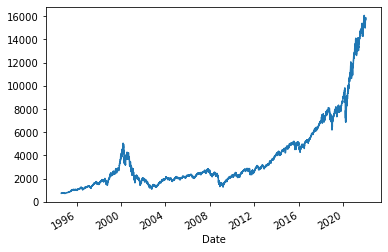

In [156]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)

print(len(data))

print(data.head())

data["Close"].plot()

<AxesSubplot:xlabel='Date'>

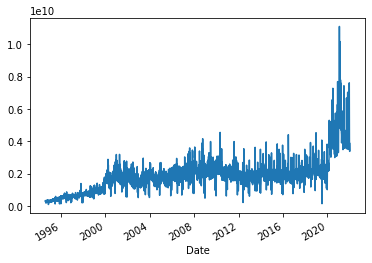

In [157]:
data["Volume"].plot()

<AxesSubplot:xlabel='Date'>

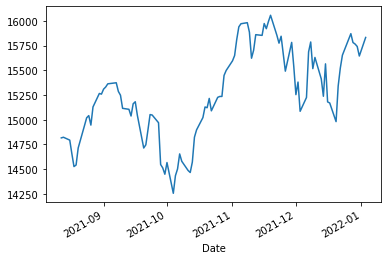

In [158]:
data.iloc[-100:]['Close'].plot()

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
1994-08-18  742.270020  744.710022  740.159973  742.169983  742.169983   
1994-08-19  743.151503  744.058167  739.745160  742.362583  742.362583   
1994-08-22  742.206516  743.224109  740.271380  742.313276  742.313276   
1994-08-23  742.941312  747.391968  742.157794  746.052749  746.052749   
1994-08-24  746.331770  750.298472  745.792298  749.755893  749.755893   

                  Volume  
Date                      
1994-08-18  3.352800e+08  
1994-08-19  2.964874e+08  
1994-08-22  2.681428e+08  
1994-08-23  3.110808e+08  
1994-08-24  3.191828e+08  


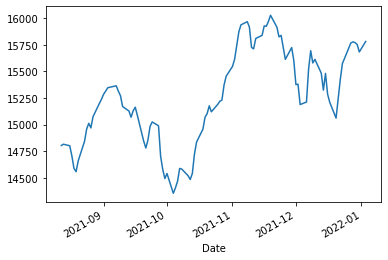

In [159]:
data = data.ewm(alpha=0.65).mean()
data = data.dropna()

data.iloc[-100:]['Close'].plot()

print(data.head())

In [160]:
live_pred_data = data.iloc[-100:-10]
live_pred_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-12,14785.237296,14836.539769,14705.891458,14803.976144,14803.976144,4.011943e+09
2021-08-13,14811.128757,14845.685648,14765.254833,14816.276904,14816.276904,4.028965e+09
2021-08-16,14785.389743,14812.531774,14664.351887,14801.640764,14801.640764,3.980134e+09
2021-08-17,14710.750131,14750.403748,14590.595084,14707.091064,14707.091064,4.091320e+09
2021-08-18,14662.318698,14715.853812,14542.303153,14589.323474,14589.323474,3.911140e+09
...,...,...,...,...,...,...
2021-12-13,15629.817215,15662.636950,15436.792691,15483.036805,15483.036805,4.519895e+09
2021-12-14,15360.810000,15438.330306,15216.154688,15323.528653,15323.528653,4.703562e+09
2021-12-15,15276.244975,15527.659455,15111.553946,15480.862079,15480.862079,5.103499e+09


In [161]:
def _produce_prediction(data, window):
    
    prediction = (data.shift(-window)['Close'] >= data['Close'])
    prediction = prediction.iloc[:-window]
    data['Pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['Close'])
data = data.dropna()
data.tail()
print(len(data))

print(data)


6879
                    Open          High           Low     Adj Close  \
Date                                                                 
1994-08-18    742.270020    744.710022    740.159973    742.169983   
1994-08-19    743.151503    744.058167    739.745160    742.362583   
1994-08-22    742.206516    743.224109    740.271380    742.313276   
1994-08-23    742.941312    747.391968    742.157794    746.052749   
1994-08-24    746.331770    750.298472    745.792298    749.755893   
...                  ...           ...           ...           ...   
2021-12-06  15220.159210  15360.835357  14966.168067  15212.278500   
2021-12-07  15409.147325  15594.350773  15318.137925  15520.795424   
2021-12-08  15592.124318  15723.238542  15513.620198  15693.822051   
2021-12-09  15675.594537  15770.565863  15511.995145  15579.128294   
2021-12-10  15645.691486  15710.137798  15489.800547  15612.584649   

                  Volume  Pred  
Date                            
1994-08-18  3.3528

In [162]:
y = data['Pred']
features = [x for x in data.columns if x not in ['Pred']]
X = data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.33)

In [163]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test.values, rf_prediction)
print('Random Forest Classifier Accuracy = ' , rf_accuracy , "\n")
print(classification_report(y_test, rf_prediction))

Random Forest Classifier Accuracy =  0.6561076155348232 

              precision    recall  f1-score   support

         0.0       0.56      0.44      0.49      1743
         1.0       0.70      0.79      0.74      2866

    accuracy                           0.66      4609
   macro avg       0.63      0.61      0.62      4609
weighted avg       0.65      0.66      0.65      4609



In [164]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
knn_prediction = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test.values, knn_prediction)
print('KNeighbors Classifier Accuracy = ' , knn_accuracy , "\n")
print(classification_report(y_test, knn_prediction))
confusion_matrix_graph = confusion_matrix(y_test, knn_prediction)

KNeighbors Classifier Accuracy =  0.5801692341071816 

              precision    recall  f1-score   support

         0.0       0.41      0.25      0.31      1743
         1.0       0.63      0.78      0.70      2866

    accuracy                           0.58      4609
   macro avg       0.52      0.52      0.51      4609
weighted avg       0.55      0.58      0.55      4609



In [165]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test.values, lr_prediction)
print('Logistic Regression Classifier Accuracy = ' , lr_accuracy , "\n")
print(classification_report(y_test, lr_prediction))

Logistic Regression Classifier Accuracy =  0.621826860490345 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1743
         1.0       0.62      1.00      0.77      2866

    accuracy                           0.62      4609
   macro avg       0.31      0.50      0.38      4609
weighted avg       0.39      0.62      0.48      4609



C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sefad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
